<a href="https://colab.research.google.com/github/asqarqyzy/Autoparts_test/blob/main/Autoparts_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_sales = pd.read_csv('/content/drive/MyDrive/SCM_data/test_fcast_sales.csv')
df_stock = pd.read_csv('/content/drive/MyDrive/SCM_data/test_fcast_stock.csv')
df_assortment = pd.read_csv('/content/drive/MyDrive/assortment_test/assortment_test.csv')

In [ ]:
df_sales.head()

Date Country  Qty  FinResult  article_id
0  2018-12-02      IT    2       5.92         343
1  2018-12-04      BN    2       5.92         343
2  2018-12-02      FI    2       5.92         343
3  2018-12-08      IT    2       5.92         343
4  2018-12-05      SE    2       5.92         343

In [ ]:
df_stock.head()

Date  Stock  article_id
0  2017-06-06    579         343
1  2017-06-07    575         343
2  2017-06-08    573         343
3  2017-06-09    573         343
4  2017-06-10    571         343

In [ ]:
df_assortment.head()

article_id  brand_number  category_name  price  sales_qty  sales_netto  \
0           1         11385  Brake pad set  37.85          1    23.120001   
1           2         11385  Brake pad set  12.57          0     0.000000   
2           3         11385  Brake pad set   8.86          3    15.659999   
3           4         11893  Brake pad set  29.92          0     0.000000   
4           5         11893  Brake pad set  20.66          2    24.880000   

   sales_revenue  sales_count_country  \
0      40.200001                    1   
1       0.000000                    0   
2      31.620000                    2   
3       0.000000                    0   
4      39.220001                    2   

                                      all_OEM_number  
0                                 15920117, 15920396  
1                                             935015  
2                        47800849, 15920103, 3221003  
3           1614412180, 5P1902, 1612434180, 77366679  
4  4106000Q1L, 410605961R, 8660000781, 410601306R...

# EDA

## Ensuring data quality

### Format: data types and header

**SALES:**

In [ ]:
# Check data types, shape, number of Nan values
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868329 entries, 0 to 868328
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        868329 non-null  object 
 1   Country     868329 non-null  object 
 2   Qty         868329 non-null  int64  
 3   FinResult   868329 non-null  float64
 4   article_id  868329 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 33.1+ MB


In [ ]:
# Convert 'Date' column to datetime type
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

In [ ]:
# Function to convert header to lower case for unified format
def header_lower_case(df):
  old_columns = df.columns.to_list()
  columns = map(lambda x: x.lower(), old_columns)
  df.rename(columns={i[0]: i[1] for i in zip(old_columns, list(columns))}, inplace=True)

header_lower_case(df_sales)

In [ ]:
# Checking uniqueness of key "date" + "country" + "article_id" in df
df_sales[df_sales.duplicated(subset=["date", "country", "article_id"])].sort_values(['article_id', 'date']).iloc[0]

date          2019-01-09 00:00:00
country                        DE
qty                             2
finresult                     6.8
article_id                      1
Name: 754490, dtype: object

In [ ]:
df_sales[(df_sales.article_id == 1) & (df_sales.date == '2019-01-09')].sort_values(['article_id', 'date'])

date country  qty  finresult  article_id
754488 2019-01-09      DE    2        6.8           1
754490 2019-01-09      DE    2        6.8           1

В продажах имеем 868тыс наблюдений. Таблица фактов. Записи должны быть уникальны в связке полей "date" + "country" + "article_id" по бизнес логике. Необходимо удалить дубликаты и повторно агрегировать данные.
Типы переменных:
* Time - date
* Continues - finresult
* Discrete - qty
* Category int- article_id
* Category str - country



**STOCK:**

In [ ]:
# Check data types, shape, number of Nan values
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647557 entries, 0 to 1647556
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Date        1647557 non-null  object
 1   Stock       1647557 non-null  int64 
 2   article_id  1647557 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 37.7+ MB


In [ ]:
# Convert 'Date' column to datetime type
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# Apply function to convert header to lower case for unified format
header_lower_case(df_stock)

In [ ]:
# Checking uniqueness of key "date" + "article_id" in df
df_stock.duplicated(subset=["date", "article_id"]).sum()

0

По остаткам на складе имеем 1.6 млн наблюдений. Таблица фактов. Записи уникальны в связке полей "date" + "article_id".
Типы переменных:
* Time - date
* Discrete - stock
* Category int- article_id



**ASSORTMENT:**:


In [ ]:
# Check data types, shape, number of Nan values
df_assortment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269071 entries, 0 to 269070
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   article_id           269071 non-null  int64  
 1   brand_number         269071 non-null  int64  
 2   category_name        269071 non-null  object 
 3   price                269071 non-null  float64
 4   sales_qty            269071 non-null  int64  
 5   sales_netto          269071 non-null  float64
 6   sales_revenue        269071 non-null  float64
 7   sales_count_country  269071 non-null  int64  
 8   all_OEM_number       247382 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# Apply function to convert header to lower case for unified format
header_lower_case(df_assortment)

In [ ]:
# Checking uniqueness of article_id in df
df_assortment.article_id.is_unique

True

В асортименте имеем 269тыс записей. Таблица - справочник товаров.  Записи уникальны относительно "article_id". Типы переменных:

* Category int- article_id, brand_number
* Category str - category_name
* Continues - price, sales_netto, sales_revenue
* Discrete - sales_qty, sales_count_country
* list of category int - all_oem_number



In [ ]:
# Query example
df_assortment[(~df_assortment.all_oem_number.isna()) & (df_assortment.all_oem_number.str.contains('15920117'))]

article_id  brand_number  category_name  price  sales_qty  \
0                1         11385  Brake pad set  37.85          1   
141546      141547         11385  Brake pad set  47.20          0   

        sales_netto  sales_revenue  sales_count_country      all_oem_number  
0         23.120001      40.200001                    1  15920117, 15920396  
141546     0.000000       0.000000                    0  15920117, 15920396

**Пример запроса:** Клиенту необходимы колодки (**category_name** = 'brake pad set') с **оем номером** '15920117', в ассортименте Autodoc есть 2 товара которые клиент может купить в связи с взаимозаменяемостью. Оба товара от одного бренда (**brand_number** = 11385) - компании поставщика Yamaha,  но отличаются по **цене**.


### Duplicates

**SALES**

In [ ]:
# Number of duplicated rows
df_sales.duplicated().sum()

138745

In [ ]:
# Delete duplicates
df_sales.drop_duplicates(inplace=True)

In [ ]:
# Number of duplicates by business key
df_sales.duplicated(subset=["date", "country", "article_id"]).sum()

13885

In [ ]:
# Check existence of negative values
df_sales[(df_sales.article_id == 95) & (df_sales.date == '2017-06-30')].sort_values(['article_id', 'date'])

date country  qty  finresult  article_id
315657 2017-06-30      SE    2       7.22          95
315659 2017-06-30      AT   -2      -7.22          95

In [ ]:
# Regrouping
df_sales = df_sales.groupby(["date", "country", "article_id"])[['qty', 'finresult']].sum().reset_index()
df_sales.head()

date country  article_id  qty  finresult
0 2017-06-30      AT          30    2       6.10
1 2017-06-30      AT          72    2       8.30
2 2017-06-30      AT          93    2       3.82
3 2017-06-30      AT          95   -2      -7.22
4 2017-06-30      AT         123    2       5.92

In [ ]:
# New shape characteristics
df_sales.shape

(715699, 5)

**STOCK**

In [ ]:
df_stock.duplicated().sum()

0

**ASSORTMENT**

In [ ]:
df_assortment.duplicated().sum()

0

В таблицах ассортимента и склада не было дубликатов.
В таблице продаж были удалены дубликаты, а также проведена повторная группировка относительно бизнес ключа. Количество записей в таблице снизилось на 150тыс, то есть до 715тыс. Замечено, что показатели количества и выручки могут принимать отрицательные значения.

### Missing values

**SALES**

In [ ]:
df_sales.isna().sum()

date          0
country       0
article_id    0
qty           0
finresult     0
dtype: int64

**STOCK**

In [ ]:
df_stock.isna().sum()

date          0
stock         0
article_id    0
dtype: int64

In [ ]:
df_assortment.category_name.unique()

array(['Brake pad set', 'Brake disc'], dtype=object)

**ASSORTMENT**

In [ ]:
df_assortment.isna().sum()

article_id                 0
brand_number               0
category_name              0
price                      0
sales_qty                  0
sales_netto                0
sales_revenue              0
sales_count_country        0
all_oem_number         21689
dtype: int64

In [ ]:
# Show rows with all_oem_number is nan
df_assortment_oem_na = df_assortment[df_assortment.all_oem_number.isna()]
df_assortment_oem_na

article_id  brand_number  category_name   price  sales_qty  \
496            497         10012  Brake pad set  562.71          0   
497            498         10012  Brake pad set  554.76          0   
499            500         10012  Brake pad set   60.34          0   
500            501         10012  Brake pad set  103.19          0   
615            616         11005     Brake disc   29.35          0   
...            ...           ...            ...     ...        ...   
267155      267156            30  Brake pad set   25.99          0   
267156      267157            30  Brake pad set   43.13          0   
267157      267158            30  Brake pad set   56.00          0   
267158      267159            30  Brake pad set   46.27          0   
267353      267354            94     Brake disc   42.53          4   

        sales_netto  sales_revenue  sales_count_country all_oem_number  
496        0.000000       0.000000                    0            NaN  
497        0.000000       0.000000                    0            NaN  
499        0.000000       0.000000                    0            NaN  
500        0.000000       0.000000                    0            NaN  
615        0.000000       0.000000                    0            NaN  
...             ...            ...                  ...            ...  
267155     0.000000       0.000000                    0            NaN  
267156     0.000000       0.000000                    0            NaN  
267157     0.000000       0.000000                    0            NaN  
267158     0.000000       0.000000                    0            NaN  
267353    97.459999     172.570007                    2            NaN  

[21689 rows x 9 columns]

* Из выгрузки видно, что продаж по товарам где нету **all_oem_number** в
большинстве нулевые, проверим сколько записей из 21689 имеют продажи.


In [ ]:
oem_na_sales_0 = df_assortment_oem_na[df_assortment_oem_na.sales_qty != 0].shape[0]
print('Количество товаров без оем номера с ненулевыми продажами:', oem_na_sales_0)
print('Количество товаров без оем номера с нулевыми продажами:', df_assortment_oem_na.shape[0] - oem_na_sales_0)
print('Доля товаров с нулевыми продажами среди товаров без оем номера, в %:',\
              int(100 - oem_na_sales_0 / df_assortment_oem_na.shape[0] * 100))

Количество товаров без оем номера с ненулевыми продажами: 1232
Количество товаров без оем номера с нулевыми продажами: 20457
Доля товаров с нулевыми продажами среди товаров без оем номера, в %: 94


* Можно заключить, что отстутствие продаж является основной причиной отсутствия оем номеров у товара.
* Проверим обратное, у всех ли товаров у которых нет продаж отстутсвуют оем номера. Или по другому, сколько товаров не имеют продаж, чтобы оценить значение.

In [ ]:
df_assortment_sales_0 = df_assortment[df_assortment.sales_qty == 0].article_id
df_assortment_sales_0.shape[0]

198220

* Так как 198220 это 71% товаров ассортимента, проверяем корректность значений продаж и по бизнес описанию поля **sales_qty** понимаем, что поле  отображает продажи за последний год и в данном случае "обратная проверка" была нецелесообразной.
* Проверим были ли продажи и когда по товарам с нулевыми продажами в последнем году.

In [ ]:
df_sales_last_year_0 = df_sales[df_sales.article_id.isin(df_assortment_sales_0)]
len(df_sales_last_year_0.article_id.unique())

1720

* 1720 товаров из ассортимента, которые имели 0 продажи в последний
год, находятся в таблице sales. Значит 179тыс товаров в ассортименте последний год не продавались и у нас нет продаж по ним. Следовательно, таблицы sales и assortment не имеют целостность данных в рамках тестового задания.
* Проверим, когда последнний раз были произведены продажи по 1720 товарам.

In [ ]:
df_sales_last_year_0.groupby('article_id').date.max().reset_index().sort_values('date')

article_id       date
1717        2152 2017-07-12
1719        2154 2017-09-18
1715        2150 2017-09-20
1716        2151 2017-09-22
1718        2153 2017-10-09
...          ...        ...
1132        1424 2020-04-08
1133        1428 2020-04-08
1134        1429 2020-04-08
1184        1494 2020-04-08
1054        1313 2020-04-08

[1720 rows x 2 columns]

In [ ]:
df_sales.date.max()

Timestamp('2020-04-08 00:00:00')

 - В последнний раз были произведены продажи 1720 товаров с 2017-07 по 2020-04. Максимальная дата в продажах по всем товарам также 2020-04, что подтверждает несопоставимость двух таблиц ассортимента и продаж из-за снимков данных в разные момент времени.

Возвратимся к вопросу пустых значений по оем номерам:
* Можно рассмотреть предположение, что товар может находиться в ассортименте, но так как его нет на складе его оем номер не проставлен. Принимая во внимания что данные ассортимента не матчатся, аналогично таблице продаж, отказываемся от проверки.
* Беря за основу, что **"Запчасти мотоциклов, автомобилей в обязательном порядке имеют оем номера с производства."**  Пустые **all_oem_number** можно заменить на константную переменную, например '0000000', для этого проанализируем, что из себя значения данного поля представляют и подтвердим что **all_oem_number** '0000000' физически не существовало в датасете.

In [ ]:
print(len(df_assortment.all_oem_number.unique()))

85352


Всего 85352 наборов оем номеров существует в ассортименте.

In [ ]:
for val in df_assortment.all_oem_number.unique():
  if  type(val) != str:
    print(val, type(val))

nan <class 'float'>


Поле **all_oem_number** имеет тип **str**, кроме **nan** значения который является типом **float**.

In [ ]:
df_assortment.all_oem_number.iloc[0]

'15920117, 15920396'

Если в наборе больше одного oem номера, то они перечислены через запятую в string-е, отображено в ячейке выше.

In [ ]:
df_assortment.all_oem_number.str.contains('00000000').sum()

75

75 товаров уже имеют значения оем номера '00000000', проверим '99999999'.

In [ ]:
df_assortment.all_oem_number.str.contains('99999999').sum()

0

In [ ]:
# Fill nan values with 99999999
df_assortment.all_oem_number.fillna('99999999', inplace=True)

### Entry errors

**SALES**

In [ ]:
df_sales.date.value_counts()

date
2019-11-29    1903
2020-01-13    1603
2020-03-02    1597
2019-06-03    1589
2019-11-04    1582
              ... 
2019-01-01     149
2017-12-24     146
2018-12-23     142
2018-12-31     139
2018-12-25     107
Name: count, Length: 1014, dtype: int64

In [ ]:
min_day = df_sales.date.min()
max_day = df_sales.date.max()
print(min_day, max_day)

2017-06-30 00:00:00 2020-04-08 00:00:00


* 1014 бизнес дат - это три года с 2017_06 по 2020_04
* Проверим есть ли продажи 365 дней в году, или в какие дни в году нет продаж.

In [ ]:
holidays = []
workdays = []
for date in pd.date_range(start=min_day, end=max_day):
  if date not in df_sales.date.unique():
    holidays.append(date)
  else:
    workdays.append(date)
print(holidays)
print(workdays)

[]
[Timestamp('2017-06-30 00:00:00'), Timestamp('2017-07-01 00:00:00'), Timestamp('2017-07-02 00:00:00'), Timestamp('2017-07-03 00:00:00'), Timestamp('2017-07-04 00:00:00'), Timestamp('2017-07-05 00:00:00'), Timestamp('2017-07-06 00:00:00'), Timestamp('2017-07-07 00:00:00'), Timestamp('2017-07-08 00:00:00'), Timestamp('2017-07-09 00:00:00'), Timestamp('2017-07-10 00:00:00'), Timestamp('2017-07-11 00:00:00'), Timestamp('2017-07-12 00:00:00'), Timestamp('2017-07-13 00:00:00'), Timestamp('2017-07-14 00:00:00'), Timestamp('2017-07-15 00:00:00'), Timestamp('2017-07-16 00:00:00'), Timestamp('2017-07-17 00:00:00'), Timestamp('2017-07-18 00:00:00'), Timestamp('2017-07-19 00:00:00'), Timestamp('2017-07-20 00:00:00'), Timestamp('2017-07-21 00:00:00'), Timestamp('2017-07-22 00:00:00'), Timestamp('2017-07-23 00:00:00'), Timestamp('2017-07-24 00:00:00'), Timestamp('2017-07-25 00:00:00'), Timestamp('2017-07-26 00:00:00'), Timestamp('2017-07-27 00:00:00'), Timestamp('2017-07-28 00:00:00'), Timestamp(

Данные по дате продажам непрерывны с шагом в день, и минимальное количество записей продаж на дату 107.

In [ ]:
df_sales.country.unique()

array(['AT', 'BN', 'CH', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU',
       'IT', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'BF', 'BG', 'CZ', 'LF',
       'LT', 'LD', 'LV', 'RO', 'EE', 'SK', 'LR', 'CF'], dtype=object)

In [ ]:
np.sort(df_sales.qty.unique())

array([-26, -20, -10,  -8,  -6,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
         4,   5,   6,   8,  10,  12,  14,  16,  18,  20,  22,  26,  30,
        32,  40,  42,  50,  52,  60,  70,  72,  80,  82, 102])

Отрицательные значения это возвраты, которые в предыдущую дату отображались с плюсом, ниже пример.

In [ ]:
df_sales[df_sales.article_id == df_sales[df_sales.qty < 0].article_id.iloc[-1]]

date country  article_id  qty  finresult
7761   2017-07-22      NO        2123    2      10.94
9373   2017-07-26      SE        2123   -2     -10.94
64108  2017-11-20      IT        2123    2      10.94
133459 2018-03-21      SE        2123    2      10.94
143021 2018-04-04      SE        2123    2      10.94
149071 2018-04-11      SE        2123    2      10.94
149820 2018-04-12      NO        2123    2      10.94
152435 2018-04-16      DE        2123    2      10.94
153522 2018-04-16      SE        2123    2      10.94
153780 2018-04-17      DE        2123   -2     -10.94
160660 2018-04-24      IT        2123    2      10.94
162260 2018-04-26      DE        2123    2      10.94
164944 2018-04-30      CH        2123    2      10.94
173865 2018-05-09      DE        2123    2      10.94
192164 2018-05-30      SE        2123    2      10.94
199060 2018-06-07      SE        2123    2      10.94
210589 2018-06-22      AT        2123    2      10.94
211503 2018-06-24      AT        2123    2      10.94
228580 2018-07-15      LT        2123    2      10.94
228595 2018-07-15      NL        2123    2      10.94
230020 2018-07-17      DE        2123    2      10.94
235209 2018-07-24      LT        2123   -2     -10.94
241625 2018-08-02      SE        2123   -2     -10.94
244519 2018-08-07      GB        2123    2      10.94
249200 2018-08-14      PL        2123    2      10.94
249350 2018-08-14      SE        2123    2      10.94
259069 2018-08-29      GB        2123   -2     -10.94
262457 2018-09-03      SE        2123    2      10.94
296209 2018-10-27      DE        2123    2      10.94
297841 2018-10-30      CH        2123    2      10.94
297925 2018-10-30      DE        2123   -2     -10.94
301304 2018-11-05      SE        2123   -2     -10.94
675350 2020-02-28      NO        2123    2      10.94
679936 2020-03-03      SE        2123    2      10.94
682655 2020-03-06      DE        2123    2      10.94
683760 2020-03-06      SE        2123    2      10.94
686486 2020-03-09      FR        2123    2      10.94
690332 2020-03-12      SE        2123    2      10.94
693960 2020-03-16      SE        2123   -2     -10.94
707972 2020-04-01      IT        2123    2      10.94
708387 2020-04-02      BN        2123    2      10.94
712302 2020-04-06      DE        2123    2      10.94
713345 2020-04-06      SE        2123    2      10.94
715687 2020-04-08      SE        2123   -2     -10.94

In [ ]:
np.sort(df_sales.finresult.unique())

array([-74.1 , -54.32, -43.38, ..., 261.12, 271.6 , 285.18])

**STOCK**

In [ ]:
df_stock.date.value_counts()

date
2020-02-12    1957
2020-02-14    1955
2020-02-13    1955
2020-02-15    1955
2020-02-18    1955
              ... 
2017-06-10     901
2017-06-13     898
2017-06-14     896
2017-06-11     896
2017-06-15     894
Name: count, Length: 1034, dtype: int64

In [ ]:
min_day_stock = df_stock.date.min()
max_day_stock = df_stock.date.max()
print(min_day, max_day)

2017-06-30 00:00:00 2020-04-08 00:00:00


In [ ]:
holidays_st = []
workdays_st = []
for date in pd.date_range(start=min_day_stock, end=max_day_stock):
  if date not in df_stock.date.unique():
    holidays_st.append(date)
  else:
    workdays_st.append(date)
print(holidays_st, sep='n')
print(len(workdays_st))

[Timestamp('2019-12-24 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-06 00:00:00')]
1034


 * 4 даты отсутствуют, не являются праздниками, так как не периодичны по годам, для них продублируем  значения предыдущего дня, тем самым сохранив шаг в день в датасете, что важно при прогнозировании.
 * Дата начала на складе раньше на 20 дней чем в продажах.

In [ ]:
# Duplicate previous rows for holidays in company
for day in holidays_st:
  temp = df_stock[df_stock.date == day + pd.Timedelta(days=-1)].copy()
  temp['date'] = day
  df_stock = pd.concat([df_stock, temp])

In [ ]:
np.sort(df_stock.stock.unique())

array([   0,    1,    2, ..., 6766, 6776, 6780])

Если на складе отсутствует товар то он маркируется нулем.

**ASSORTMENT**

In [ ]:
df_assortment.head()

article_id  brand_number  category_name  price  sales_qty  sales_netto  \
0           1         11385  Brake pad set  37.85          1    23.120001   
1           2         11385  Brake pad set  12.57          0     0.000000   
2           3         11385  Brake pad set   8.86          3    15.659999   
3           4         11893  Brake pad set  29.92          0     0.000000   
4           5         11893  Brake pad set  20.66          2    24.880000   

   sales_revenue  sales_count_country  \
0      40.200001                    1   
1       0.000000                    0   
2      31.620000                    2   
3       0.000000                    0   
4      39.220001                    2   

                                      all_oem_number  
0                                 15920117, 15920396  
1                                             935015  
2                        47800849, 15920103, 3221003  
3           1614412180, 5P1902, 1612434180, 77366679  
4  4106000Q1L, 410605961R, 8660000781, 410601306R...

In [ ]:
np.sort(df_assortment.article_id.unique())

array([     1,      2,      3, ..., 269069, 269070, 269071])

In [ ]:
brand_number_unique = np.sort(df_assortment.brand_number.unique())
print(len(brand_number_unique))
print(brand_number_unique)

173
[     1      2      3     12     21     22     23     30     35     39
     43     48     49     50     54     55     57     62     65     73
     76     86     89     94     95    101    108    110    121    127
    129    133    134    143    152    165    166    193    195    199
    308    343    381    383    442    448    480    482    484    489
    490    833   1156   1178   1269   1297   1307   1471   4346   4364
   4377   4396   4625   4682   4770   4815   4821   4869   4887   4894
   4931   4948   4975   4986   4993   4999   6008   6265   6359   6368
   6473   6479   6558   6862   6896   6933   6983   6984   6985  10005
  10012  10029  10064  10086  10095  10103  10120  10121  10129  10142
  10180  10191  10204  10205  10207  10221  10246  10249  10323  10324
  10385  10388  10394  10564  10565  10580  10583  10668  10674  10721
  10744  10753  10768  10777  10814  10866  10912  10914  11005  11047
  11091  11094  11115  11117  11160  11224  11255  11297  11307  11360
  

Всего 173 бренда продаются в компании.

In [ ]:
df_assortment.category_name.unique()

array(['Brake pad set', 'Brake disc'], dtype=object)

Продаются два вида товара:
* 'Brake pad set' - колодки
* 'Brake disc' - тормозные диски

In [ ]:
df_assortment.columns

Index(['article_id', 'brand_number', 'category_name', 'price', 'sales_qty',
       'sales_netto', 'sales_revenue', 'sales_count_country',
       'all_oem_number'],
      dtype='object')

In [ ]:
df_assortment[[ 'price', 'sales_qty',
       'sales_netto', 'sales_revenue', 'sales_count_country']].describe()

price      sales_qty    sales_netto  sales_revenue  \
count  269071.000000  269071.000000  269071.000000  269071.000000   
mean       42.259906      18.328616     277.584225     491.411871   
std        67.547173     194.035488    2267.440329    4007.207736   
min         0.020000      -4.000000    -522.919998    -751.459991   
25%        19.160000       0.000000       0.000000       0.000000   
50%        28.670000       0.000000       0.000000       0.000000   
75%        45.150000       1.000000      11.420000      20.895000   
max      1909.900000   38528.000000  157162.222435  376959.837392   

       sales_count_country  
count        269071.000000  
mean              1.502146  
std               3.813227  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.000000  
max              29.000000

**Описательная статистика**
* Численные показатели скошены, так как показатели медианы и среднего значения сильно отличаются, причина в том что указаны показатели продаж за последний год, тем самым 70% товаров не активны и принимают нулевые значения.
* Показатели продаж имеют выбросы то есть максимальные значения, так как у компании есть b2b клиенты, при основной составляющей базы b2c.

In [ ]:
df_assortment_last_year = df_assortment[df_assortment.sales_qty != 0]
df_assortment_last_year[[ 'price', 'sales_qty',
       'sales_netto', 'sales_revenue', 'sales_count_country']].describe()

price     sales_qty    sales_netto  sales_revenue  \
count  70851.000000  70851.000000   70851.000000   70851.000000   
mean      32.816827     69.606625    1054.177941    1866.230080   
std       27.362608    373.382867    4325.112295    7643.120326   
min        3.350000     -4.000000    -522.919998    -751.459991   
25%       19.010000      2.000000      36.994999      65.000000   
50%       26.360000      7.000000     118.259997     205.813698   
75%       37.570000     28.000000     491.969997     871.535001   
max      986.970000  38528.000000  157162.222435  376959.837392   

       sales_count_country  
count         70851.000000  
mean              5.679045  
std               5.612291  
min               1.000000  
25%               1.000000  
50%               3.000000  
75%               8.000000  
max              29.000000

unique, sense of column

## Outliers

**ASSORTMENT**

* отфильтруем количество продаж за последний год


In [ ]:
df_assortment_last_year.head()

article_id  brand_number  category_name  price  sales_qty  sales_netto  \
0            1         11385  Brake pad set  37.85          1    23.120001   
2            3         11385  Brake pad set   8.86          3    15.659999   
4            5         11893  Brake pad set  20.66          2    24.880000   
10          11         11893  Brake pad set  18.04          1    10.720000   
11          12         11893  Brake pad set  21.82          9   121.070000   

    sales_revenue  sales_count_country  \
0       40.200001                    1   
2       31.620000                    2   
4       39.220001                    2   
10      18.709999                    1   
11     211.519999                    6   

                                       all_oem_number  
0                                  15920117, 15920396  
2                         47800849, 15920103, 3221003  
4   4106000Q1L, 410605961R, 8660000781, 410601306R...  
10                 1636413980, 1612911480, 1609000680  
11                 1610428780, 1619790980, 1647860280

In [ ]:
df_assortment_last_year_brand = df_assortment_last_year.groupby('brand_number').sales_qty.sum().reset_index()
df_assortment_last_year_brand.sort_values('sales_qty', ascending=False)

brand_number  sales_qty
96         100015    1400264
13             65     868898
4              30     695651
1               3     410549
95         100001     288512
..            ...        ...
89          11360          1
102        100382          1
103        100415          1
66          10129          1
108        101119          1

[110 rows x 2 columns]

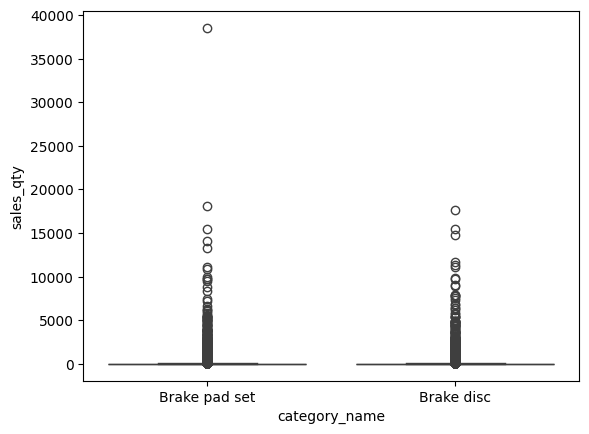

In [ ]:
df_assortment_last_year = df_assortment[df_assortment.sales_qty != 0]

sns.boxplot(data=df_assortment_last_year, y='sales_qty', x='category_name')
plt.show()

боксплот

аномалии

## Relationships

**SALES**

**STOCK**

**ASSORTMENT**

хитмап, Correlations

## Univariate analyses

**SALES**

**STOCK**

**ASSORTMENT**

hist, boxplot, stats

for time - pattern and trend

## Bivariate analyses: Relationships/Correlations

**SALES**

In [ ]:
# # Create year feature
df_sales['year'] = df_sales.date.dt.year

# df_sales_year_sum = df_sales.groupby('year')[['qty', 'finresult']].sum()
# df_sales_year_mean = df_sales.groupby('year')[['qty', 'finresult']].mean()
# fig, axes = plt.subplots(2, 2)
# sns.barplot(data=df_sales_year_sum, x=df_sales_year_sum.index, y='qty', ax=axes[0,0])
# sns.barplot(data=df_sales_year_sum, x=df_sales_year_sum.index, y='finresult', ax=axes[0,1])
# sns.barplot(data=df_sales_year_mean, x=df_sales_year_mean.index, y='qty', ax=axes[1,0])
# sns.barplot(data=df_sales_year_mean, x=df_sales_year_mean.index, y='finresult', ax=axes[1,1])
# fig.title('Количество продаж по всем странам')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# sns.scatterplot(data=df_sales_country, x=df_sales_country.index, y='qty')
# plt.title('Среднее количество продаж по всем странам')
# plt.xticks(rotation=90)
# plt.show()

По общему количеству продаж лидируют страны - SE, FR, DE.


**STOCK**

**ASSORTMENT**

scatterplot

## Multivariate analyses

**SALES**

**STOCK**

**ASSORTMENT**

pattern, trend, PCA, Cluster analyses

## EDA conclusion

patterns anomalies, insights

# Questions and hypotheses testing

## a.	У набора данных есть прогностический потенциал.

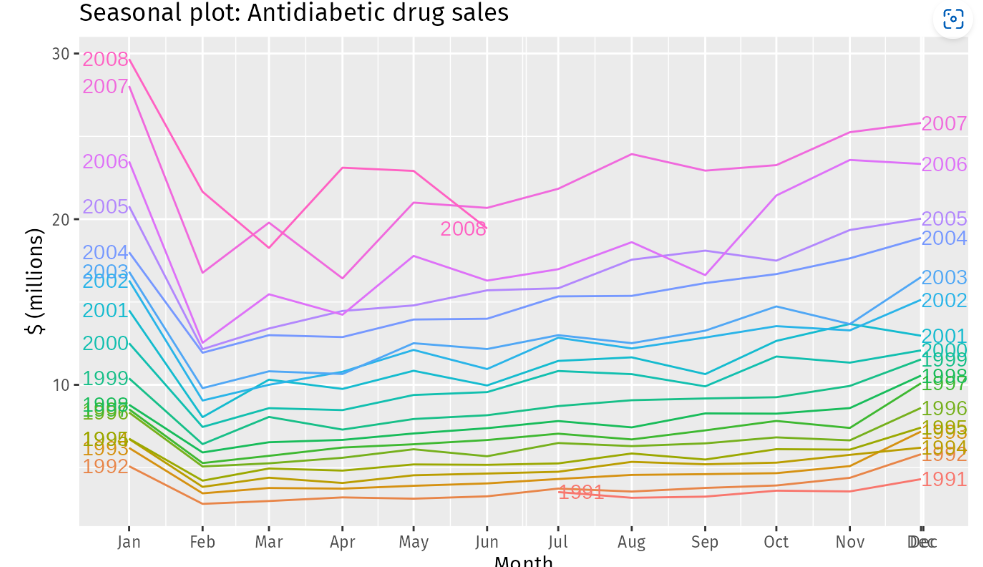

seasonal plot - forecast book

с помощью методов машинного обучения мы можем спрогнозировать продажи по странам и категориям, или категориям, или товарам. Группировка прогнозирования продаж на ваше усмотрение.

* исключаем первый и последний месяц так как там неполные месяца продаж 2017-06-30, 2020-04-08

In [ ]:
# !pip install pycountry

In [ ]:
import pycountry

In [ ]:
countries = pycountry.countries
country_name = {}
for country in countries:
    country_name[country.alpha_2] = country.name

In [ ]:
df_sales['country_name'] = df_sales.country.apply(lambda x: country_name.get(x, x))
df_sales['month'] = df_sales['date'].dt.month
df_sales['category_name'] = df_sales.merge(df_assortment, on='article_id', how='left').category_name

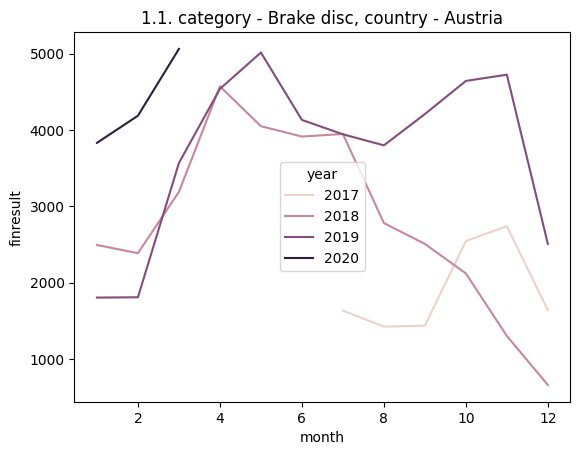

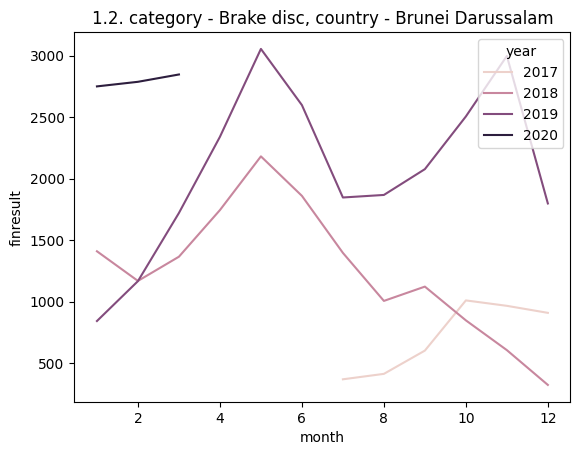

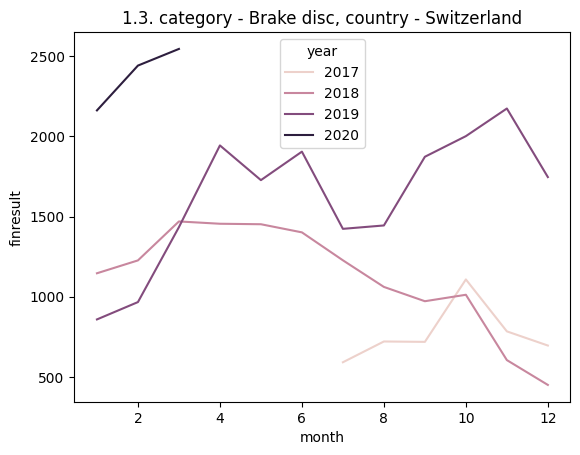

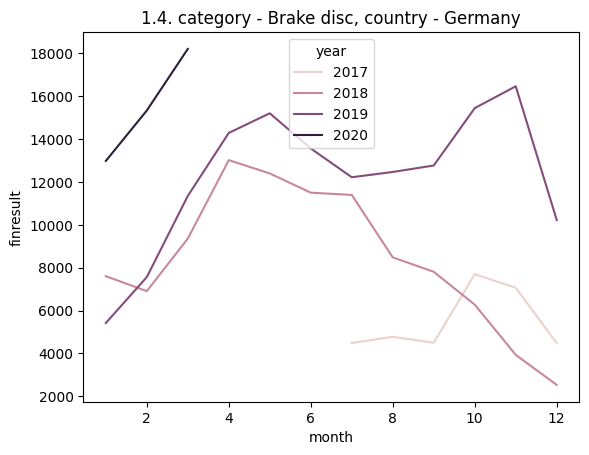

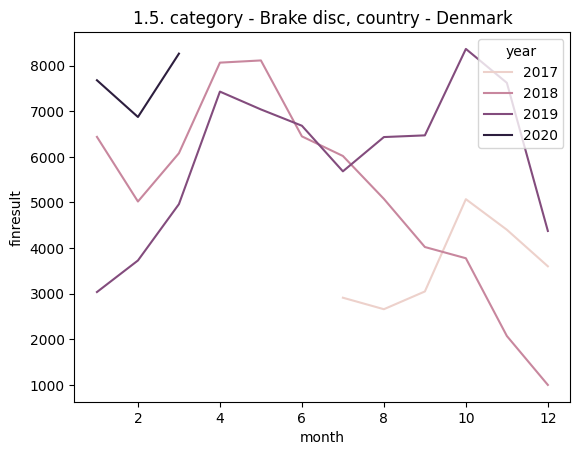

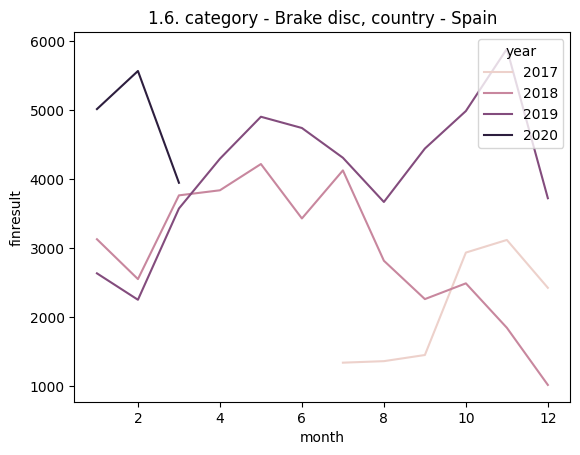

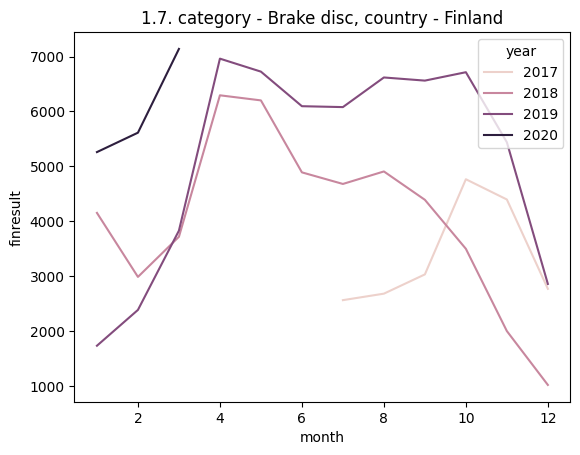

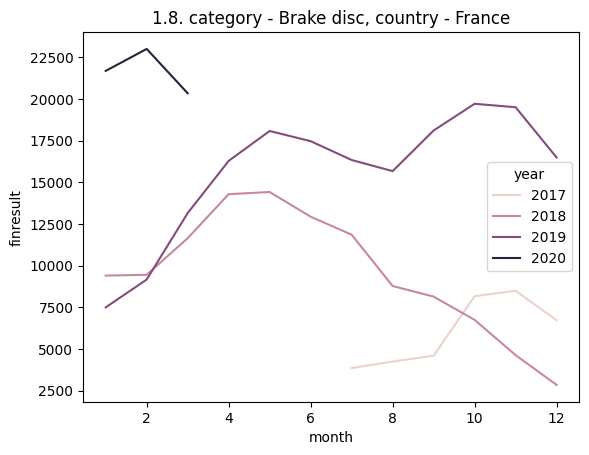

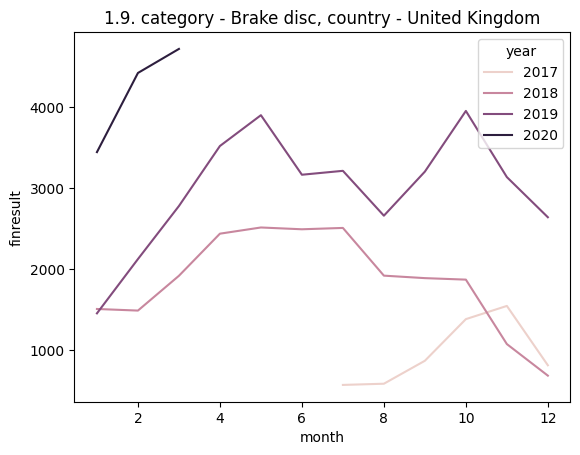

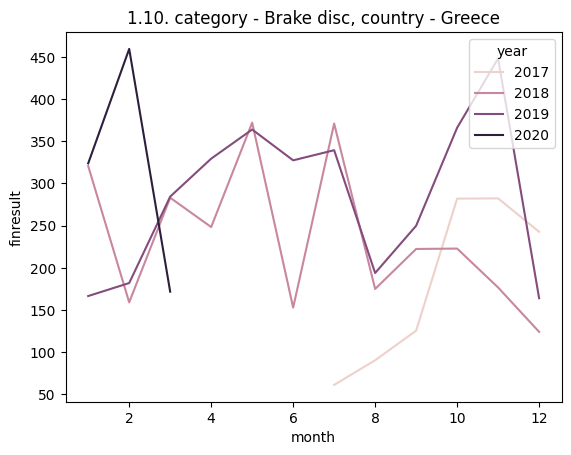

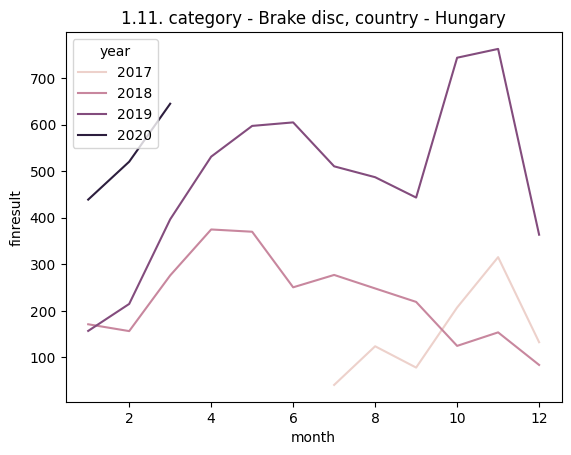

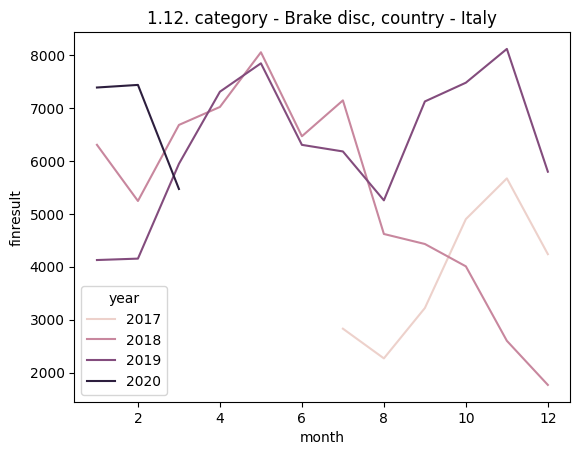

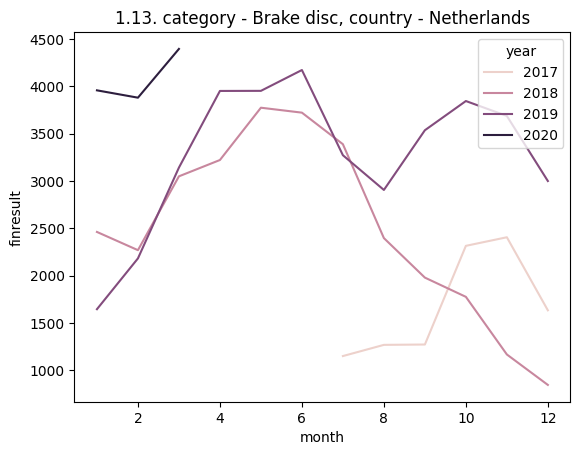

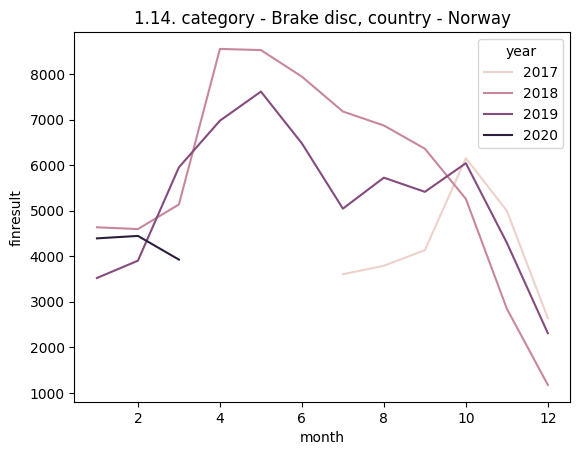

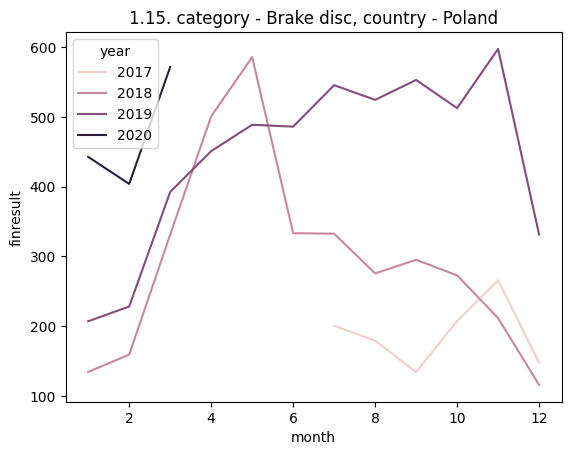

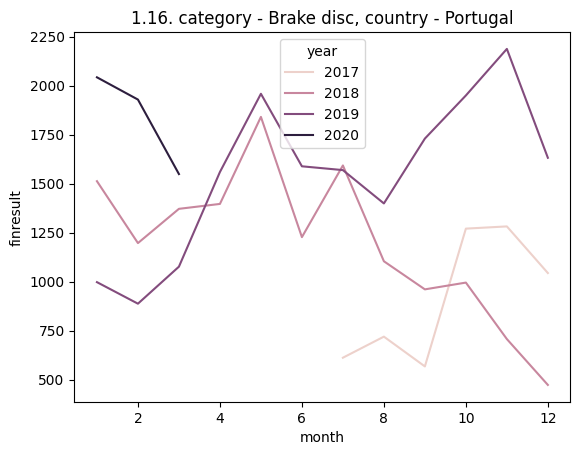

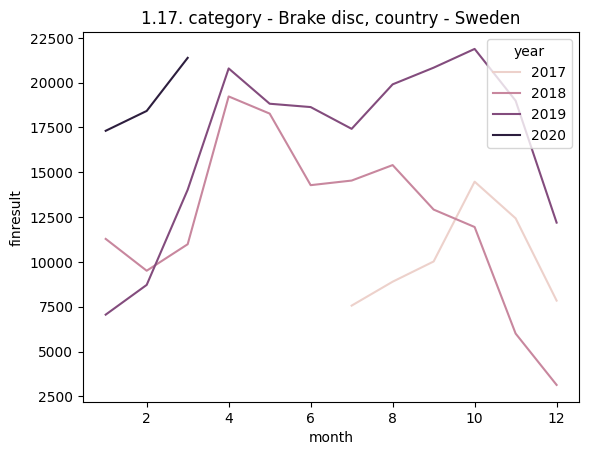

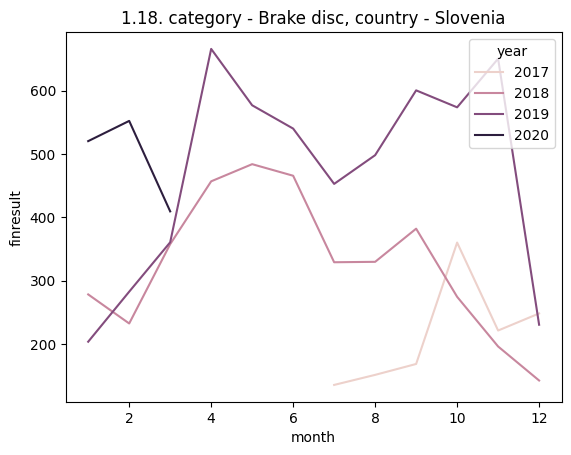

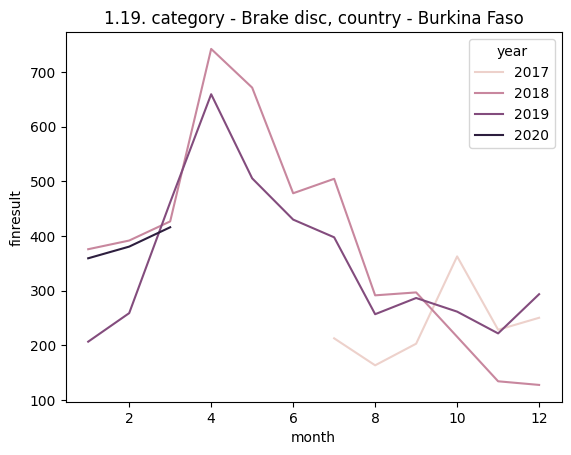

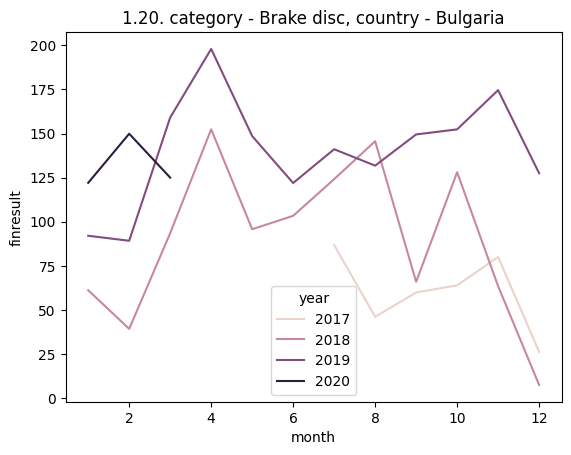

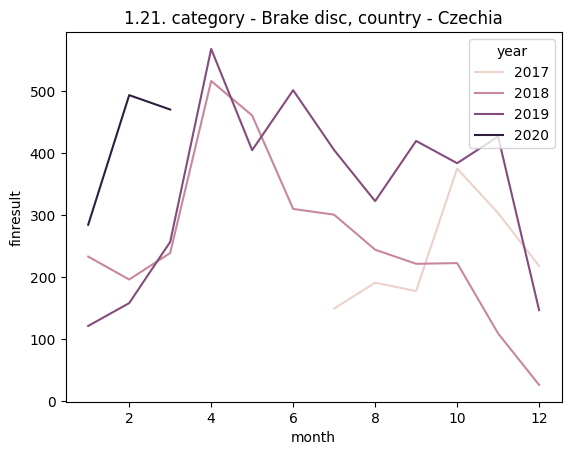

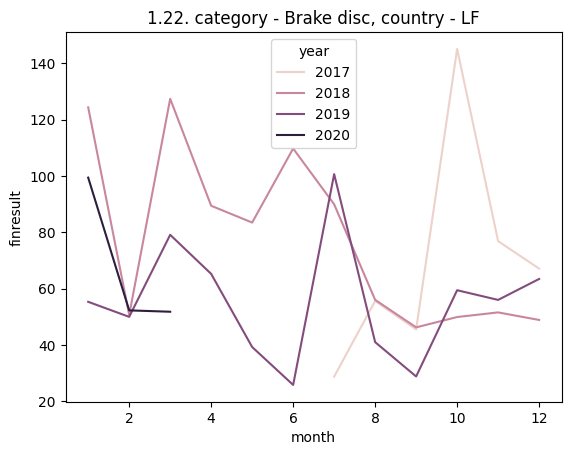

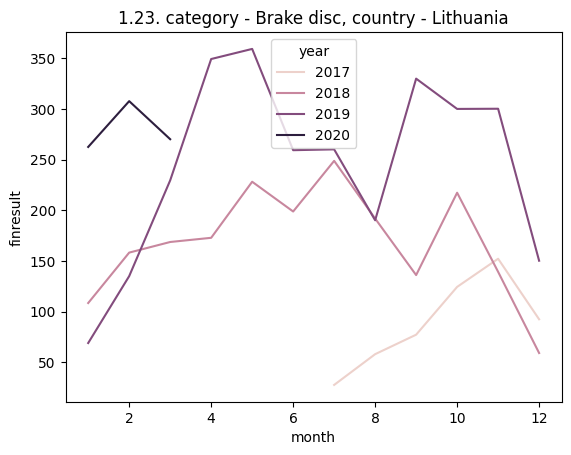

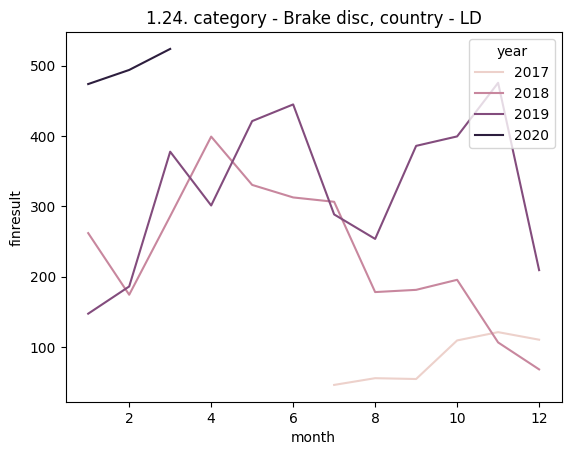

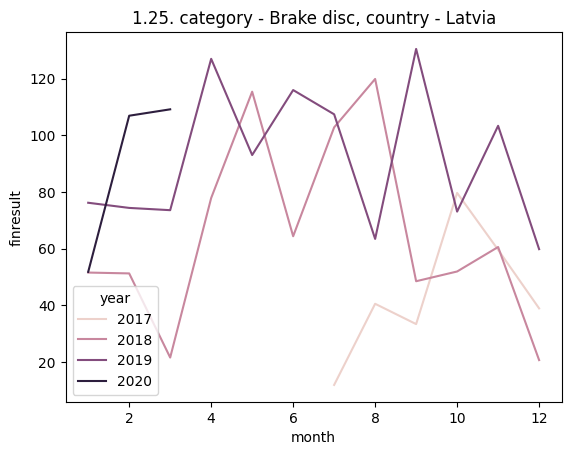

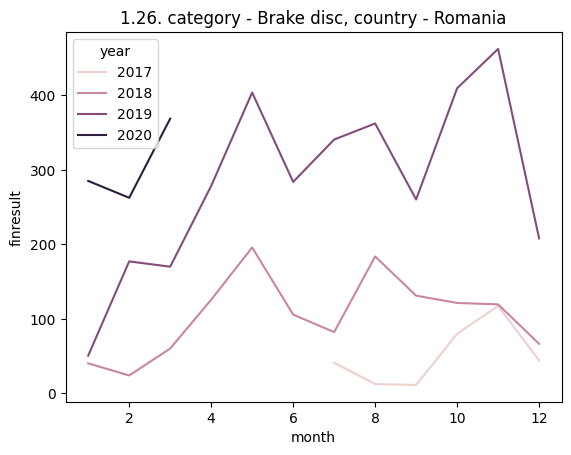

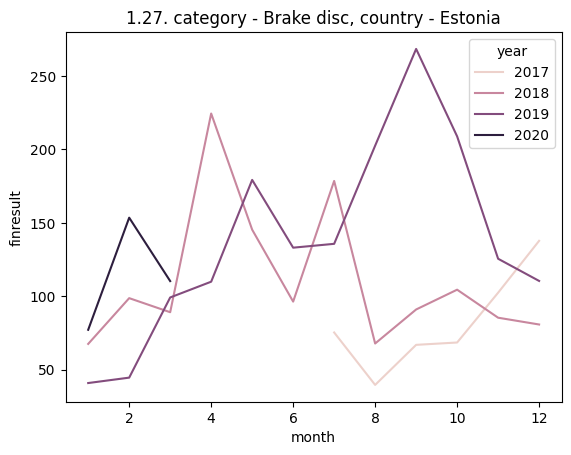

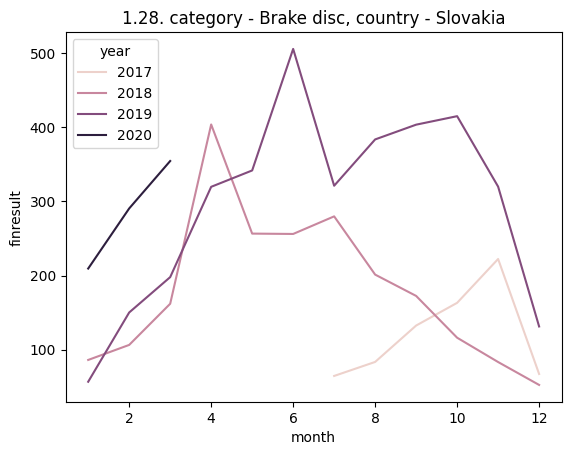

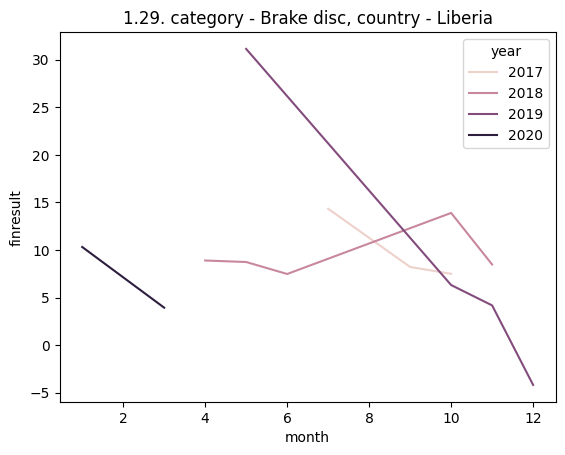

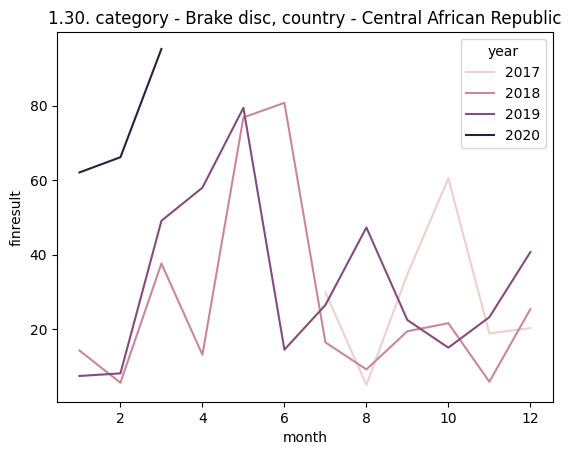

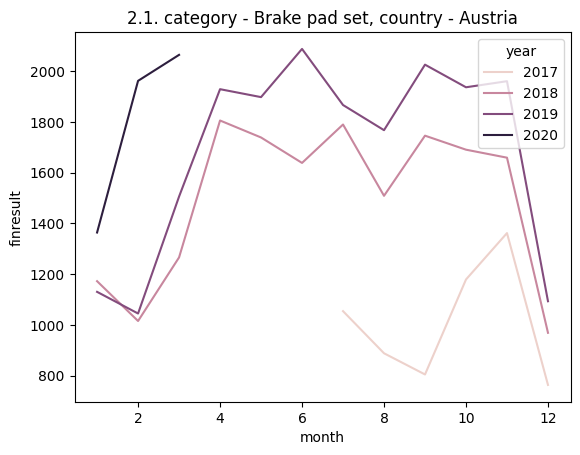

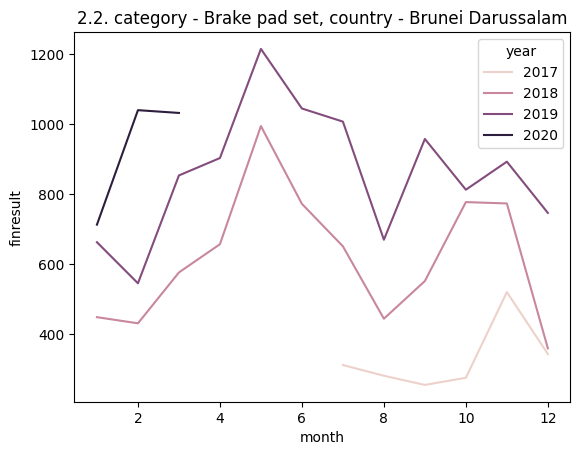

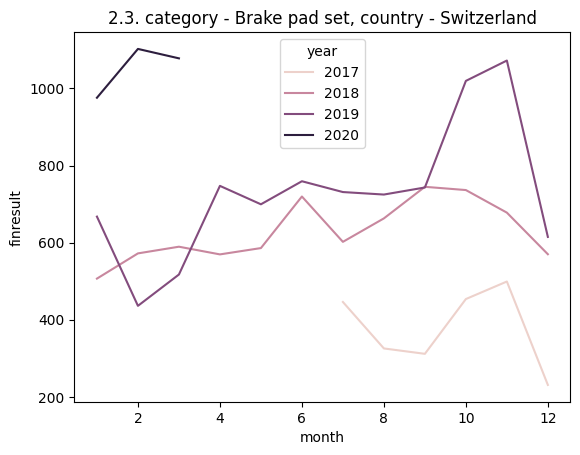

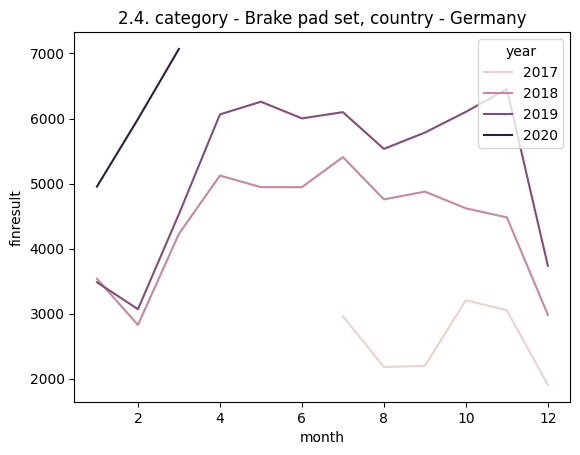

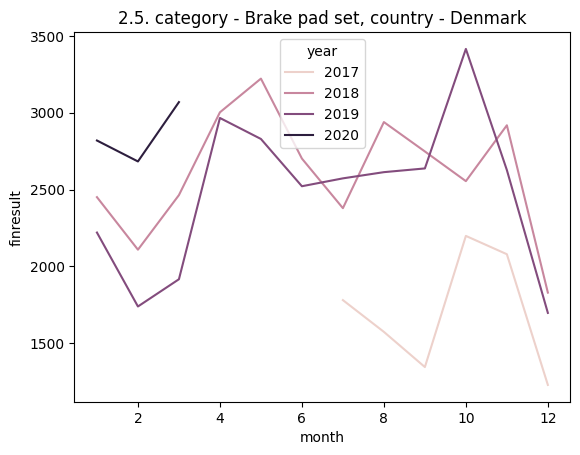

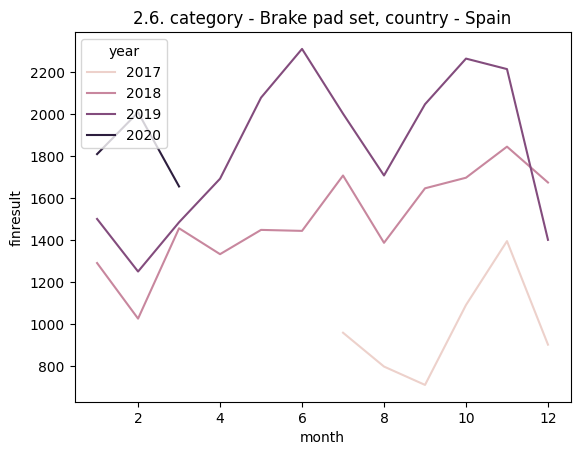

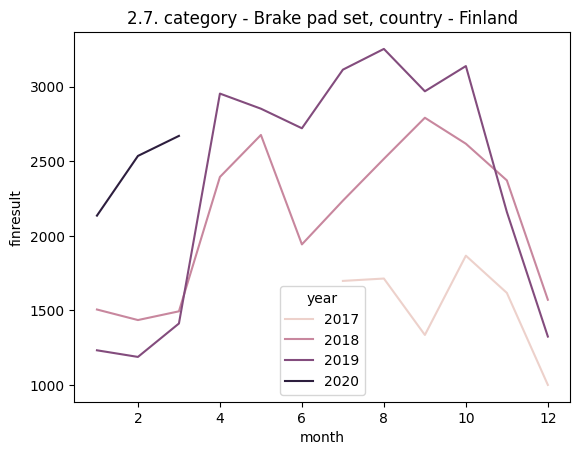

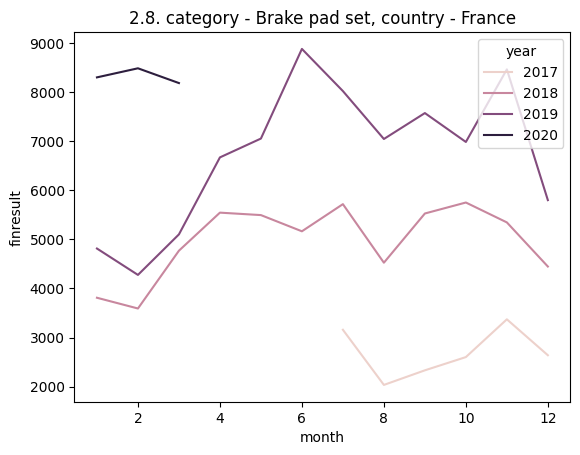

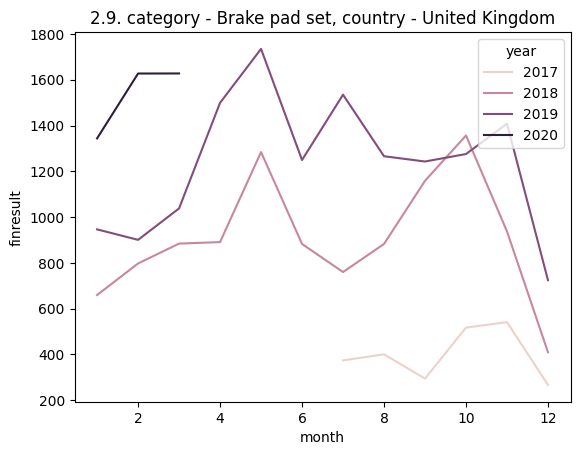

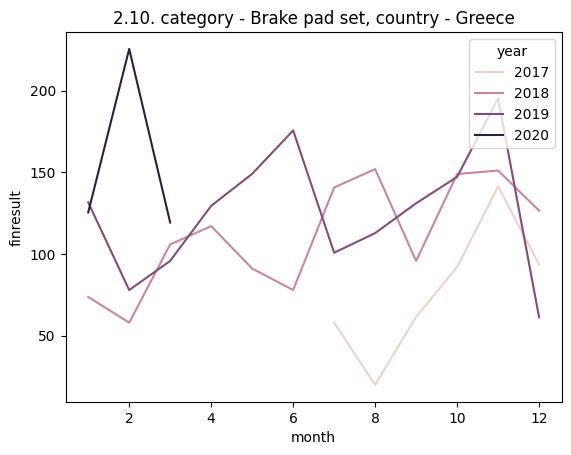

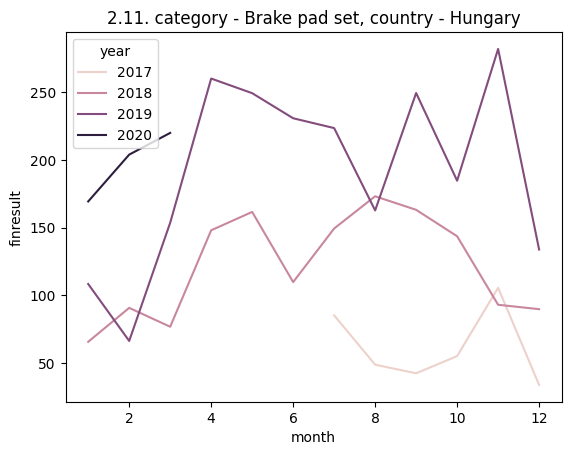

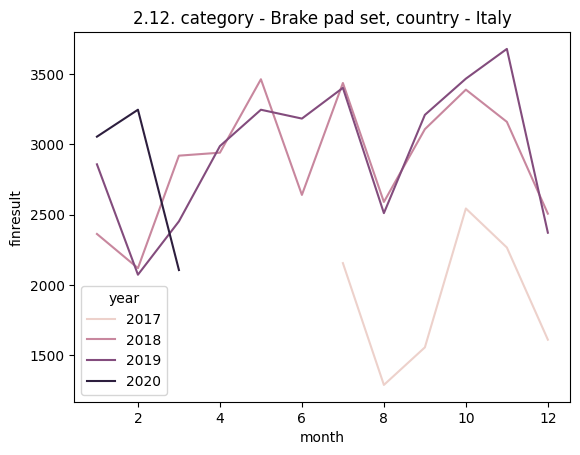

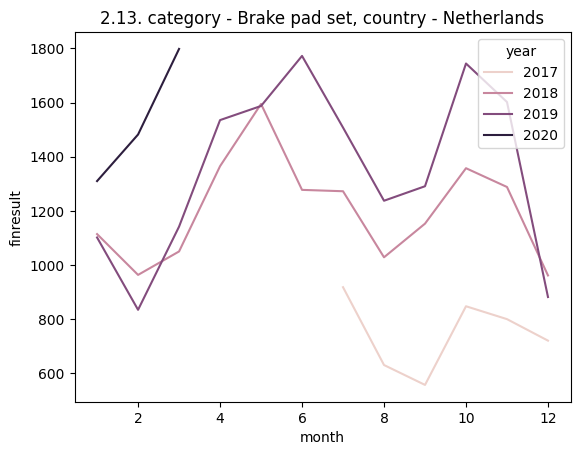

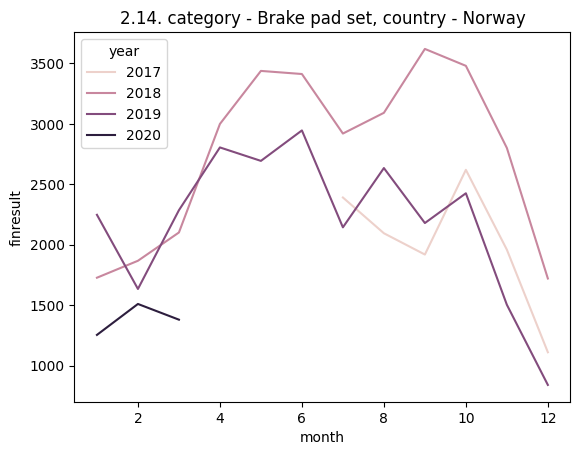

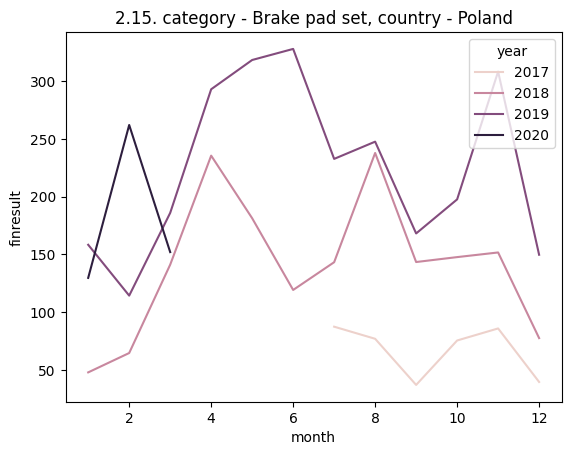

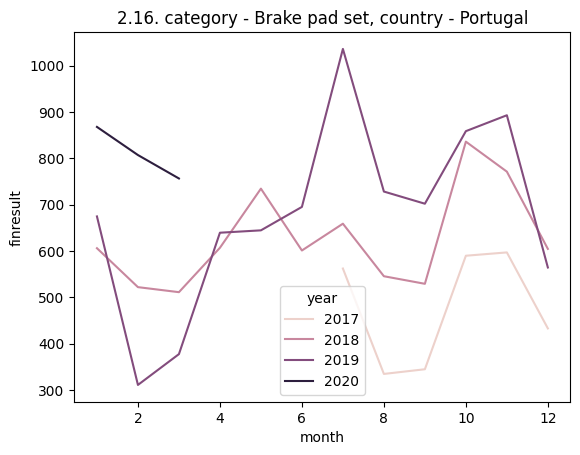

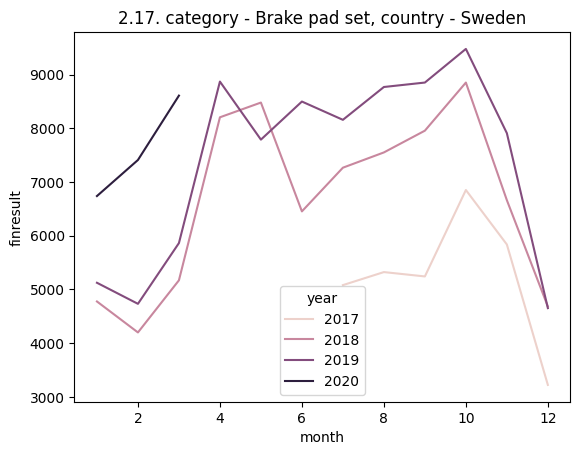

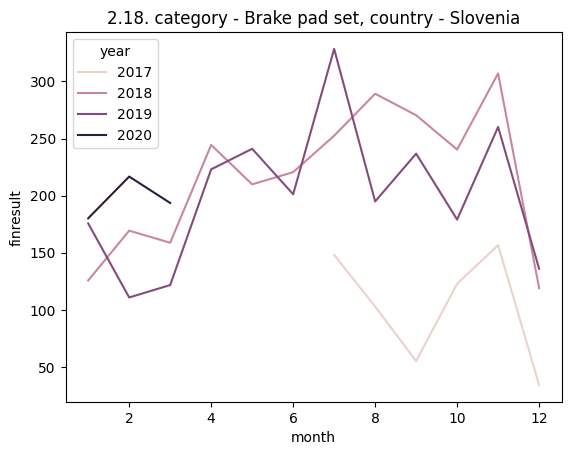

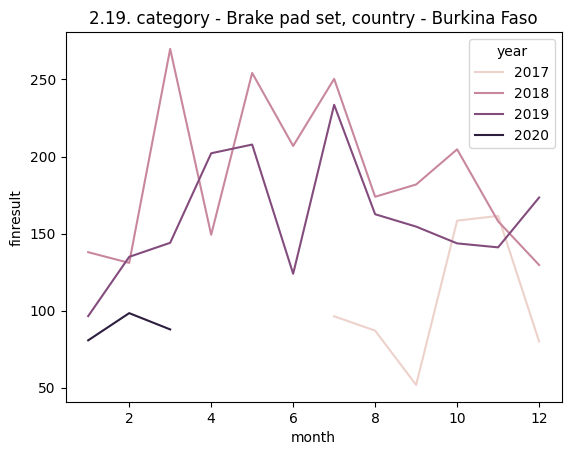

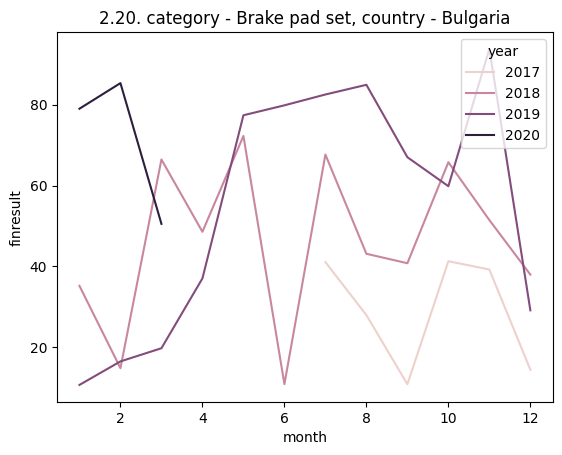

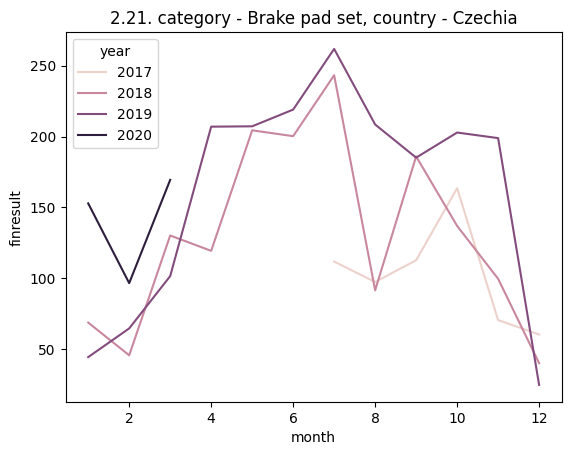

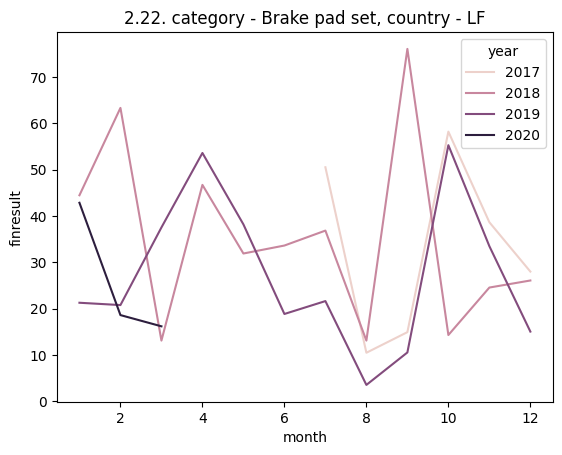

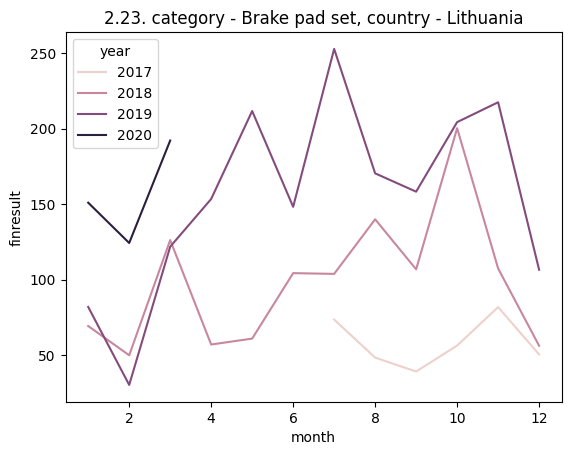

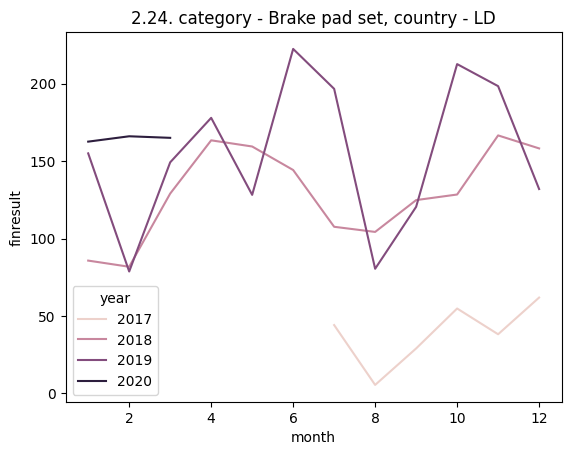

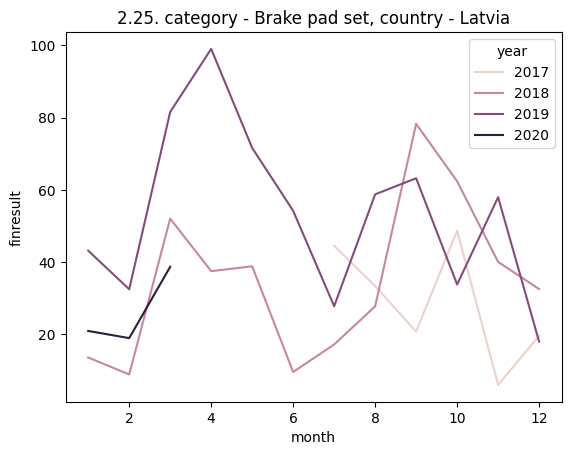

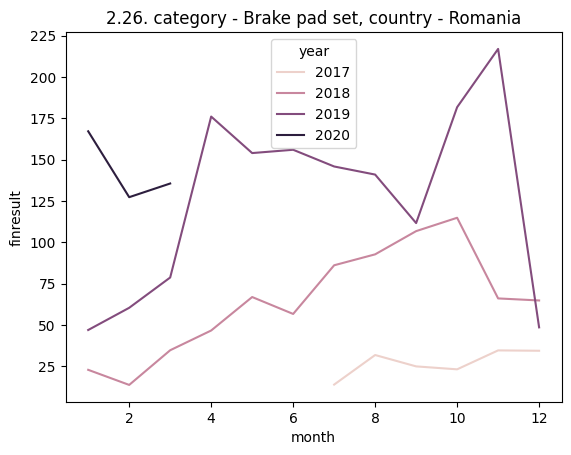

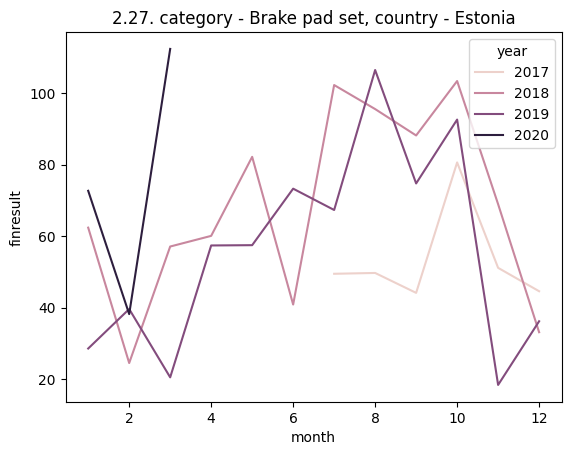

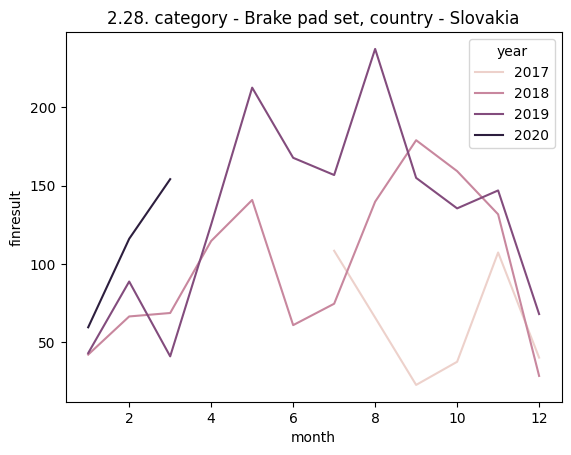

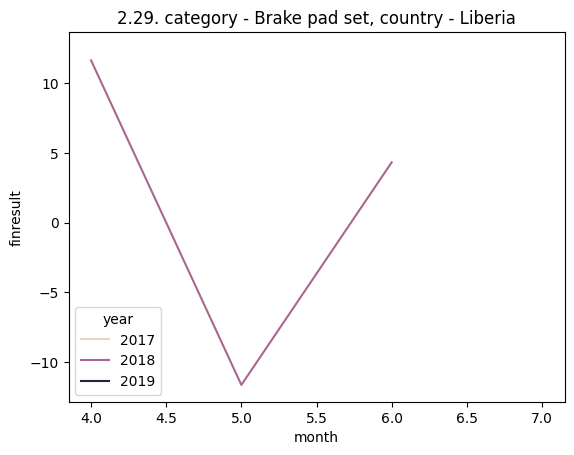

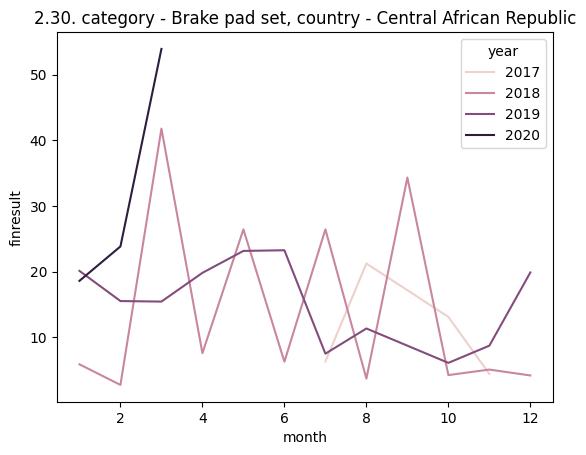

In [ ]:
counter_cat = 0
for category in df_sales.category_name.unique():
  counter_cat += 1
  counter_country = 0
  for country in df_sales.country_name.unique():
    counter_country += 1
    df_sales_country = df_sales[(df_sales.country_name == country) & (df_sales.category_name == category) &\
                                (df_sales.date > '2017-06-30') & (df_sales.date < '2020-04-01')]
    df_sales_mm = df_sales_country.groupby(['year', 'month'])[['qty', 'finresult']].sum().reset_index()
    sns.lineplot(data=df_sales_mm, x='month', y='finresult', hue='year')
    plt.title(f'{counter_cat}.{counter_country}. category - {category}, country - {country}')
    plt.show()


## b.	Ассортимент в категории взаимозаменяем по ОЕM номерам

мы можем сгруппировать ассортимент по ОЕM номерам в группы альтернатив для дальнейшей оценки спроса группы и анализа.

## c. Можем определить оптимальный уровень запасов по месяцам

Динамика запасов логируется, мы можем определить оптимальный уровень запасов по месяцам в зависимости от сезонности, спрогнозировать запасы по товарам или категориям товаров, или определить интервалы уровня запасов по товарам, товарным категориям в штуках.

относительно категории

колодка - **летом** уходит, быстро ездят, часто тормозят по сравнению с зимой
**страны** европейский рынок разница жазда кыста не играет,нет снега

тормозные диски - от перегрева изнашиваются, жазда
от **бренда** торм диски зависят от качества, перфорированные - жаксы/ диски - можно много не закзать, если обычные диски - много заказывают быстро ломаютсяё
спрос относительно **категории**

## d. Mожем понять сколько запасов нам необходимо для оптимального покрытия спроса каждый месяц

## e. Xотим понять как товары деляться по ценовому сегменту

ходовые дорогие или нет

в разрезе категорий / бренд /
